In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import itertools
import tqdm
import random

### Data

In [3]:
tetragonal = pd.read_csv('data/tetragonal.csv')
tetragonal = tetragonal[tetragonal.Zr > 0]

monoclinic = pd.read_csv('data/monoclinic.csv')
monoclinic = monoclinic[monoclinic.Zr > 0]

In [4]:
inputs = ['T']
features = ['en_p', 'ea', 'valence', 'pettifor', 'rad_ionic', 'rad_slater', 'rad_clementi']
outputs = ['a']

In [5]:
nonlinear = []
for f1, f2 in itertools.combinations_with_replacement(features, 2):
    newfeature = f1 + '_' + f2
    tetragonal[newfeature] = tetragonal[f1] * tetragonal[f2]
    monoclinic[newfeature] = monoclinic[f1] * monoclinic[f2]

    nonlinear.append(newfeature)

### ML

In [6]:
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [7]:
def get_stats(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rsq, _ = stats.pearsonr(y_true, y_pred)
    
    return rmse, rsq
    
def plot_test(ax, reg, Xt, yt, unit='Å', color_temperature=True):   
    if color_temperature:
        color = Xt[:, 0]
    else:
        color = '#ff7f0e'

    y_pred = reg.predict(Xt)
    ax.scatter(yt, y_pred, alpha=0.6, c=color, cmap='plasma')

    rmse, rsq = get_stats(yt, y_pred)

    lim_min = min(np.min(yt), np.min(y_pred))
    lim_max = max(np.max(yt), np.max(y_pred))
    lims = (lim_min, lim_max)

    ax.plot(lims, lims, 'k', zorder=-1)

    ax.annotate(
        'RMSE = %.2e %s\nR$^2$ = %.2f' % (rmse, unit, rsq),
        (0.05, 0.96),
        xycoords='axes fraction',
        va='top',
        fontsize=12
    )

    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax
    
    
def plot_train_test(reg, Xr, Xt, yr, yt, unit='Å', figtitle=''):
    fig, ax_fig = plt.subplots(1, 2, figsize=(8, 4))

    for idx, (title, color, x_plot, y_plot) in enumerate(zip(
        ['train', 'test'],
        ['#1f77b4', '#ff7f0e'],
        [Xr, Xt],
        [yr, yt]
    )):
        ax = ax_fig[idx]

        y_pred = reg.predict(x_plot)
        ax.scatter(y_plot, y_pred, alpha=0.6, c=color)

        rmse, rsq = get_stats(y_plot, y_pred)

        lim_min = min(np.min(y_plot), np.min(y_plot))
        lim_max = max(np.max(y_plot), np.max(y_plot))
        lims = (lim_min, lim_max)

        ax.plot(lims, lims, 'k', zorder=-1)

        ax.annotate(
            'RMSE = %.2e %s\nR$^2$ = %.2f' % (rmse, unit, rsq),
            (0.05, 0.96),
            xycoords='axes fraction',
            va='top',
            fontsize=12
        )

        ax.set_xlabel(f'True lattice parameter ({unit})', fontsize=12)

        if idx == 0:
            ax.set_ylabel(f'Predicted lattice parameter ({unit})', fontsize=12)

        ax.set_title(title)

        ax.set_xlim(lims)
        ax.set_ylim(lims)
    
    fig.suptitle(figtitle)
    plt.show()

In [8]:
inputs = ['T']

def get_model(features, output, df):
    X = df[inputs + features].values
    y = df[output].values.reshape(-1)
    Xr, Xt, yr, yt = train_test_split(X, y, test_size=0.3)
    
    reg  = BayesianRidge(compute_score=True)
    reg.fit(Xr, yr)
    
    return reg, Xr, Xt, yr, yt

In [9]:
features = ['en_p', 'ea', 'valence', 'pettifor', 'rad_ionic', 'rad_slater', 'rad_clementi']
outputs_tetragonal = ['a', 'c']
outputs_monoclinic = ['a', 'b', 'c', 'beta']

### Features selection

In [10]:
summary = pd.DataFrame(
    columns=['features', 'parameter', 'rmse', 'rsq']
)

In [11]:
NRUNS = 50

for linearity, feat in zip(['linear', 'nonlinear'], [features, features + nonlinear]):

    for _ in range(NRUNS):
        for df, lattice, outputs in zip(
            [tetragonal, monoclinic],
            ['tetragonal', 'monoclinic'],
            [outputs_tetragonal, outputs_monoclinic],
        ):

            for output in outputs:
                reg, Xr, Xt, yr, yt = get_model(list(feat), output, df)

                rmse, rsq = get_stats(yt, reg.predict(Xt))

                summary = summary.append({
                    'features': linearity,
                    'parameter': '%s_%s' % (lattice, output),
                    'rmse': rmse,
                    'rsq': rsq
                }, ignore_index=True)

In [12]:
fsummary = summary.groupby(['features', 'parameter']).mean()['rmse'].unstack()
fsummary_rsq = summary.groupby(['features', 'parameter']).mean()['rsq'].unstack()

In [13]:
fsummary

parameter,monoclinic_a,monoclinic_b,monoclinic_beta,monoclinic_c,tetragonal_a,tetragonal_c
features,,,,,,
linear,0.004173,0.005651,0.062861,0.004467,0.004616,0.005968
nonlinear,0.004073,0.007105,0.065346,0.005588,0.003539,0.005150


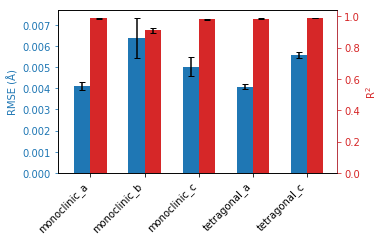

In [14]:
fig, ax = plt.subplots(figsize=(5, 3))
means = summary.groupby('parameter').mean().drop('monoclinic_beta')
errors = summary.groupby('parameter').std().drop('monoclinic_beta') / np.sqrt(NRUNS)

width=0.3
cax = '#1f77b4'
ctax = '#d62728'

p1 = means['rmse'].plot.bar(
    yerr=errors['rmse'],
    capsize=3,
    ax=ax,
    position=1,
    width=width,
    color=cax
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_xlabel('')
ax.set_ylabel('RMSE (Å)')

tax = ax.twinx()
p2 = means['rsq'].plot.bar(
    yerr=errors['rsq'],
    capsize=3,
    ax=tax,
    position=0,
    width=width,
    color=ctax
)
tax.set_ylabel('R$^2$')

ax.set_xlim(left=-0.6)

for ax_, color in zip([ax, tax], [cax, ctax]):
    ax_.yaxis.label.set_color(color)
    ax_.spines["right"].set_edgecolor(color)
    ax_.tick_params(axis='y', colors=color)

plt.show()

In [38]:
summary.groupby(['features', 'parameter']).mean()['rmse']

features   parameter      
linear     monoclinic_a       0.004190
           monoclinic_b       0.005209
           monoclinic_beta    0.062345
           monoclinic_c       0.004745
           tetragonal_a       0.004678
           tetragonal_c       0.006186
nonlinear  monoclinic_a       0.003850
           monoclinic_b       0.003994
           monoclinic_beta    0.062901
           monoclinic_c       0.005124
           tetragonal_a       0.003624
           tetragonal_c       0.005443
Name: rmse, dtype: float64

Text(0, 0.5, 'RMSE (Å)')

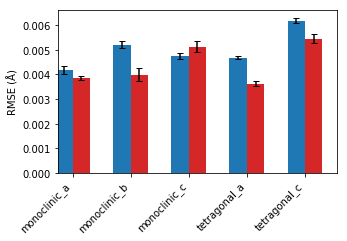

In [41]:
fig, ax = plt.subplots(figsize=(5, 3))
means = summary.groupby(['features', 'parameter']).mean()['rmse']
errors = summary.groupby(['features', 'parameter']).std()['rmse'] / np.sqrt(NRUNS)

width=0.3
lin_color = '#1f77b4'
nonlin_color = '#d62728'

p1 = means['linear'].drop('monoclinic_beta').plot.bar(
    yerr=errors['linear'].drop('monoclinic_beta'),
    capsize=3,
    ax=ax,
    position=1,
    width=width,
    color=cax
)

p2 = means['nonlinear'].drop('monoclinic_beta').plot.bar(
    yerr=errors['nonlinear'].drop('monoclinic_beta'),
    capsize=3,
    ax=ax,
    position=0,
    width=width,
    color=ctax
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_xlabel('')
ax.set_ylabel('RMSE (Å)')

# tax = ax.twinx()
# p2 = means['rsq'].plot.bar(
#     yerr=errors['rsq'],
#     capsize=3,
#     ax=tax,
#     position=0,
#     width=width,
#     color=ctax
# )
# tax.set_ylabel('R$^2$')

# ax.set_xlim(left=-0.6)

# for ax_, color in zip([ax, tax], [cax, ctax]):
#     ax_.yaxis.label.set_color(color)
#     ax_.spines["right"].set_edgecolor(color)
#     ax_.tick_params(axis='y', colors=color)

# plt.show()